# Modeling - LendingClub Loan Listings Data

Meskerem Goshime

Data Source: https://www.kaggle.com/datasets/husainsb/lendingclub-issued-loans

“LendingClub is a US peer-to-peer lending company, headquartered in San Francisco, California.” The company “enables borrowers to create unsecured personal loans between 1,000𝑎𝑛𝑑 40,000. The standard loan period is three years. Investors can search and browse the loan listings on Lending Club website and select loans that they want to invest in based on the information supplied about the borrower, amount of loan, loan grade, and loan purpose. Investors make money from interest. Lending Club makes money by charging borrowers an origination fee and investors a service fee.” (source: https://www.kaggle.com/datasets/husainsb/lendingclub-issued-loans?select=lc_2016_2017.csv)​

This study aims to help LendingClub in making informed lending decisions and investors make informed investment decisions

In [51]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


In [2]:
X_train = pd.read_csv('../data/processed/X_train.csv')
y_train = pd.read_csv('../data/processed/y_train.csv')
X_test = pd.read_csv('../data/processed/X_test.csv')
y_test = pd.read_csv('../data/processed/y_test.csv')

In [3]:
# converting y_train and y_test to numpy arrays
y_train = y_train['loan_status'].to_numpy()
y_test = y_test['loan_status'].to_numpy()

In [4]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(656443, 33) (656443,) (164111, 33) (164111,)


# Feature Importance - Random Forest

In [5]:
# Feature Importance

rf = RandomForestClassifier(n_estimators=200, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

importance = rf.feature_importances_
columns = X_train.columns
importance = pd.DataFrame({'column': columns, 'importance': importance})
importance = importance.sort_values('importance', ascending=False)
imp_features = importance.iloc[0:10, :]
imp_features = imp_features['column'].to_numpy()
imp_features

array(['dti', 'annual_inc', 'loan_amnt', 'int_rate', 'open_acc',
       'emp_length', 'sub_grade', 'inq_last_6mths', 'delinq_2yrs',
       'grade'], dtype=object)

In [6]:
# Taking the top 10 important features

X_train = X_train[imp_features]
X_train.head(3)

,dti,annual_inc,loan_amnt,int_rate,open_acc,emp_length,sub_grade,inq_last_6mths,delinq_2yrs,grade
0,-1.146909,4.182613,2.391644,-0.930613,0.264161,-0.821394,-0.760369,-0.696715,-0.366546,-0.604579
1,0.423021,0.007524,0.014601,0.169171,-0.865627,1.089267,0.317199,0.303337,-0.366546,0.156731
2,-0.576248,0.079097,-0.698512,-0.015647,-0.865627,1.089267,0.163261,-0.696715,-0.366546,0.156731


In [7]:
X_test = X_test[imp_features]
X_test.head(3)

,dti,annual_inc,loan_amnt,int_rate,open_acc,emp_length,sub_grade,inq_last_6mths,delinq_2yrs,grade
0,1.127163,-0.899067,0.430583,-0.743513,0.640758,-1.094346,-0.606431,-0.696715,-0.366546,-0.604579
1,0.274845,1.725275,2.391644,2.323106,1.958844,-0.548443,2.164459,5.303592,-0.366546,2.440662
2,0.861426,0.031382,1.975661,0.166890,-0.300733,-0.275491,0.163261,-0.696715,-0.366546,0.156731


# Hyperparameter Tuining - Random Forest

In [10]:
# Tuning Random Forest Hyperparameters with GridSearchCV.
# The GridSearchCV chose 300 for n_estimators.

from sklearn.model_selection import GridSearchCV

params = {'n_estimators':[100, 200, 300]}
rf = RandomForestClassifier(random_state=1)

gs = GridSearchCV(estimator=rf, param_grid=params, n_jobs=-1)

gs_rf = gs.fit(X_train, y_train)
y_pred = gs_rf.predict(X_test)

print(gs_rf.best_score_)
print(gs_rf.best_params_)


0.930942976179345
{'n_estimators': 300}


In [14]:
# Tuininig the Random Forest Classifier manually.
# The manual tuining seems to run faster and I was able to test more values. 
# I am going to go with 500 as it seems to work better, so I am going to go with that.

n = [50, 100, 300, 500, 800]
for i in n:
    rf = RandomForestClassifier(n_estimators=i, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)  
    y_pred_probs_rf = rf.predict_proba(X_test)[:,1]
    fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_probs_rf)
    print('n_estimators:', i, 'ROC/AUC Score:', roc_auc_score(y_test, y_pred_probs_rf))
    cm_rf = confusion_matrix(y_test, y_pred_rf)
    print(cm_rf)

n_estimators: 50 ROC/AUC Score: 0.7231499051158256
[[152382    139]
 [ 11539     51]]
n_estimators: 100 ROC/AUC Score: 0.7340407147656589
[[152425     96]
 [ 11546     44]]
n_estimators: 300 ROC/AUC Score: 0.7411626548728726
[[152444     77]
 [ 11555     35]]
n_estimators: 500 ROC/AUC Score: 0.7426437437243611
[[152450     71]
 [ 11557     33]]
n_estimators: 800 ROC/AUC Score: 0.743579921120807
[[152457     64]
 [ 11556     34]]


# Random Forest model with the chosen n_estimators value.

In [59]:
rf = RandomForestClassifier(n_estimators=500, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

# using the most important features made only a small difference.

RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=1)

[[152450     71]
 [ 11557     33]]
ROC/AUC Score:  0.7426437437243611


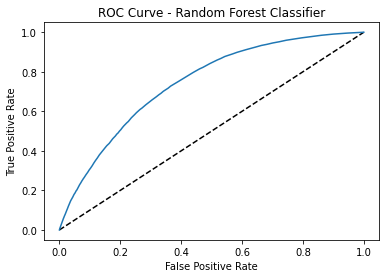

In [65]:
y_pred_rf = rf.predict(X_test)  
cm_rf = confusion_matrix(y_test, y_pred_rf)
print(cm_rf)

# ROC AUC Score

y_pred_probs_rf = rf.predict_proba(X_test)[:,1]
from sklearn.metrics import roc_auc_score
print('ROC/AUC Score: ', roc_auc_score(y_test, y_pred_probs_rf))

# ROC Curve
from sklearn.metrics import roc_curve
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_probs_rf)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr_rf, tpr_rf)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest Classifier')
plt.show()



# Optimal Threshold Value - Random Forest

In [61]:
# Defining a function to find the optimal threshold value
def optimal_thr(tpr, fpr, thresholds):
    tpr_fpr_tres = pd.DataFrame({'tpr':tpr, 'fpr':fpr, 'thresholds':thresholds, 'tpr-fpr':tpr-fpr})
    tpr_fpr_tres = tpr_fpr_tres.sort_values(by='tpr-fpr', ascending=False)
    return tpr_fpr_tres

optimal_thr(tpr_rf, fpr_rf, thresholds_rf)

# Optimal threshold value seems to be 0.07

,tpr,fpr,thresholds,tpr-fpr
253,0.727437,0.365320,0.072,0.362117
254,0.735289,0.374067,0.070,0.361223
255,0.743141,0.382708,0.068,0.360433
256,0.751596,0.391625,0.066,0.359971
250,0.701294,0.341363,0.078,0.359931
...,...,...,...,...
2,0.000259,0.000000,0.654,0.000259
3,0.000259,0.000020,0.624,0.000239
1,0.000086,0.000000,0.692,0.000086
0,0.000000,0.000000,1.692,0.000000


In [62]:
# new class predictions using the optimal threshold value, which is 0.07.

pred_new_rf = pd.DataFrame({'y_test': y_test, 'y_pred_proba': y_pred_probs_rf, 'y_pred': y_pred_rf})
bad_loans = pred_new[pred_new['y_pred_proba']>=0.072]
bad_loans['class_new']=1
good_loans = pred_new[pred_new['y_pred_proba']<0.072]
good_loans['class_new']=0
good_loans.reset_index(drop=True, inplace=True)
bad_loans.reset_index(drop=True, inplace=True)
pred_new_rf = pd.concat([good_loans, bad_loans], axis=0)
print(pred_new_rf['class_new'].value_counts())
print(pred_new_rf.head())

0    102744
1     61367
Name: class_new, dtype: int64
   y_test  y_pred_proba  y_pred  class_new
0       0          0.00       0          0
1       0          0.00       0          0
2       0          0.00       0          0
3       0          0.02       0          0
4       0          0.01       0          0


C:\Users\meske\AppData\Local\Temp/ipykernel_26144/3845527429.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bad_loans['class_new']=1
C:\Users\meske\AppData\Local\Temp/ipykernel_26144/3845527429.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_loans['class_new']=0


In [63]:
# Evaluating the confusion metrix with the new threshold value

cm_rf = confusion_matrix(pred_new_rf['y_test'], pred_new_rf['class_new'])
print(cm_rf)

# We are now catching a lot more of the bad loans. 
# We are still missing 3248 bad loans, as predicting them as good loans.
# With the default 0.5 threshold value, we were missing 11637 bad loans. 
# As a tradeoff, we are now misclassifing a lot more of the good loans as bad loans (59713).

[[99246 53275]
 [ 3498  8092]]


In [64]:
# Evaluating the classification report for the new threshold value

cl_report_rf = classification_report(pred_new_rf['y_test'], pred_new_rf['class_new'])
print(cl_report_rf)

              precision    recall  f1-score   support

           0       0.97      0.65      0.78    152521
           1       0.13      0.70      0.22     11590

    accuracy                           0.65    164111
   macro avg       0.55      0.67      0.50    164111
weighted avg       0.91      0.65      0.74    164111



# Logistic regression Model

In [37]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_pred_probs_lr = lr.predict_proba(X_test)[:,1]


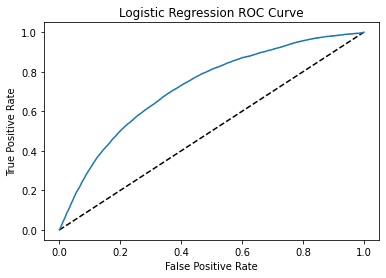

In [38]:
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_probs_lr)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr_lr, tpr_lr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

In [39]:
# ROC/AUC Score

print('ROC/AUC Score: ', roc_auc_score(y_test, y_pred_probs_lr))

# The ROC/AUC Score is a little bit less than that of the RandomForest Model

ROC/AUC Score:  0.722759154245151


In [44]:
cm_lr = confusion_matrix(y_test, y_pred_lr)
print(cm_lr)

[[152520      1]
 [ 11590      0]]


In [46]:
cl_report_lr = classification_report(pred_new_lr['y_test'], pred_new_lr['class_new'])
print(cl_report_lr)

              precision    recall  f1-score   support

           0       0.97      0.63      0.76    152521
           1       0.13      0.70      0.21     11590

    accuracy                           0.64    164111
   macro avg       0.55      0.67      0.49    164111
weighted avg       0.91      0.64      0.72    164111



In [47]:
# Finding the optimal threshold value

optimal_thr(tpr_lr, fpr_lr, thresholds_lr)

# The optimal threshold is 0.0.065015

,tpr,fpr,thresholds,tpr-fpr
13993,0.702847,0.369143,0.065015,0.333705
13997,0.703020,0.369385,0.064987,0.333635
13755,0.691890,0.358272,0.066346,0.333618
14003,0.703279,0.369687,0.064948,0.333592
14001,0.703192,0.369602,0.064958,0.333591
...,...,...,...,...
20552,0.998965,0.999371,0.005433,-0.000406
20558,0.999310,0.999725,0.004382,-0.000415
20555,0.999137,0.999580,0.004796,-0.000443
20556,0.999137,0.999646,0.004626,-0.000509


In [48]:
# Making predictions using the optimal threshold value (using Prediction_optimal function defined a while back).
pred_new_lr = pd.DataFrame({'y_test': y_test, 'y_pred_proba': y_pred_probs_lr, 'y_pred': y_pred_lr})
bad_loans_lr = pred_new_lr[pred_new_lr['y_pred_proba']>=0.065015]
bad_loans_lr['class_new']=1
good_loans_lr = pred_new_lr[pred_new_lr['y_pred_proba']<0.065015]
good_loans_lr['class_new']=0
good_loans_lr.reset_index(drop=True, inplace=True)
bad_loans_lr.reset_index(drop=True, inplace=True)
pred_new_lr = pd.concat([good_loans_lr, bad_loans_lr], axis=0)
print(pred_new_lr['class_new'].value_counts())

#prediction_optimal(y_test, y_pred_probs_lr, y_pred_lr, 0.066120)
print(pred_new_lr.head())
print(pred_new_lr['class_new'].value_counts())

0    99662
1    64449
Name: class_new, dtype: int64
   y_test  y_pred_proba  y_pred  class_new
0       0      0.033398       0          0
1       0      0.058912       0          0
2       0      0.050097       0          0
3       0      0.028555       0          0
4       0      0.019249       0          0
0    99662
1    64449
Name: class_new, dtype: int64


C:\Users\meske\AppData\Local\Temp/ipykernel_26144/1667885789.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bad_loans_lr['class_new']=1
C:\Users\meske\AppData\Local\Temp/ipykernel_26144/1667885789.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_loans_lr['class_new']=0


In [49]:
cm_lr = confusion_matrix(pred_new_lr['y_test'], pred_new_lr['class_new'])
cm_lr


array([[96218, 56303],
       [ 3444,  8146]], dtype=int64)

# Gradient Boosting Model

In [41]:
from sklearn.ensemble import GradientBoostingClassifier

In [42]:
# Searching for the best paramaters using manual tuining.

n = [50, 100, 200, 400, 600]
for i in n:
    gb = GradientBoostingClassifier(
    n_estimators=i,
    learning_rate=0.1,
    max_depth=3)
    gb.fit(X_train, y_train)
    y_pred_gb = gb.predict(X_test)
    y_pred_probs_gb = gb.predict_proba(X_test)[:,1]
    fpr_gb, tpr_gb, thresholds_gb = roc_curve(y_test, y_pred_probs_gb)
    print('n_estimators:', i, 'ROC/AUC Score:', roc_auc_score(y_test, y_pred_probs_gb))

n_estimators: 50 ROC/AUC Score: 0.736095647565221
n_estimators: 100 ROC/AUC Score: 0.7462947853928249
n_estimators: 200 ROC/AUC Score: 0.7568687131212115
n_estimators: 400 ROC/AUC Score: 0.7634268006908046
n_estimators: 600 ROC/AUC Score: 0.7661286464865029


In [43]:
# The performance of the model seems to increase with increasing n_estimators value.
# However, going beyond 600 for n_estimators will make the processing time very long. 

# Reducing the max_depth to 1 and increasing n_estimators to 800.

gb = GradientBoostingClassifier(
    n_estimators=800,
    learning_rate=0.1,
    max_depth=1)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
y_pred_probs_gb = gb.predict_proba(X_test)[:,1]

In [53]:
fpr_gb, tpr_gb, thresholds_gb = roc_curve(y_test, y_pred_probs_gb)
print('n_estimators:', 800, 'ROC/AUC Score:', roc_auc_score(y_test, y_pred_probs_gb))

n_estimators: 800 ROC/AUC Score: 0.7661109756854427


In [45]:
# In the end, I am choosing 600 for n_estimators and 3 for max_depth.

In [52]:
# Running Gradient Boosting Classifier with chosen parameters.

gb = GradientBoostingClassifier(
    n_estimators=600,
    learning_rate=0.1,
    max_depth=3)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
y_pred_probs_gb = gb.predict_proba(X_test)[:,1]

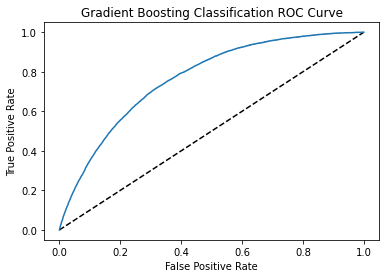

0.7661109756854427


In [54]:
fpr_gb, tpr_gb, thresholds_gb = roc_curve(y_test, y_pred_probs_gb)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr_gb, tpr_gb)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gradient Boosting Classification ROC Curve')
plt.show()

# ROC/AUC Score

print(roc_auc_score(y_test, y_pred_probs_gb))


In [57]:
cm_gb = confusion_matrix(y_test, y_pred_gb)
print(cm_gb)

[[152487     34]
 [ 11572     18]]


In [58]:
cl_report_gb = classification_report(pred_new_gb['y_test'], pred_new_gb['class_new'])
print(cl_report_gb)

              precision    recall  f1-score   support

           0       0.97      0.68      0.80    152521
           1       0.15      0.72      0.24     11590

    accuracy                           0.68    164111
   macro avg       0.56      0.70      0.52    164111
weighted avg       0.91      0.68      0.76    164111



In [48]:
# Finding the optimal threshold value

optimal_thr(tpr_gb, fpr_gb, thresholds_gb)

# The optimal threshold is 0.073607

,tpr,fpr,thresholds,tpr-fpr
13949,0.717429,0.318520,0.073813,0.398909
13865,0.713546,0.314671,0.074494,0.398875
13867,0.713632,0.314789,0.074473,0.398843
13947,0.717343,0.318500,0.073818,0.398842
13869,0.713719,0.314881,0.074453,0.398837
...,...,...,...,...
22630,1.000000,0.999856,0.001847,0.000144
22631,1.000000,0.999869,0.001846,0.000131
0,0.000000,0.000000,1.999485,0.000000
22632,1.000000,1.000000,0.001712,0.000000


In [55]:
# Making predictions using the optimal threshold value (using Prediction_optimal function defined a while back).

pred_new_gb = pd.DataFrame({'y_test': y_test, 'y_pred_proba': y_pred_probs_gb, 'y_pred': y_pred_gb})
bad_loans_gb = pred_new_gb[pred_new_gb['y_pred_proba']>=0.073813]
bad_loans_gb['class_new']=1
good_loans_gb = pred_new_gb[pred_new_gb['y_pred_proba']<0.073813]
good_loans_gb['class_new']=0
good_loans_gb.reset_index(drop=True, inplace=True)
bad_loans_gb.reset_index(drop=True, inplace=True)
pred_new_gb = pd.concat([good_loans_gb, bad_loans_gb], axis=0)
print(pred_new_gb['class_new'].value_counts())
print(pred_new_gb.head())

0    107216
1     56895
Name: class_new, dtype: int64
   y_test  y_pred_proba  y_pred  class_new
0       0      0.016489       0          0
1       0      0.066184       0          0
2       0      0.033607       0          0
3       0      0.027959       0          0
4       0      0.008251       0          0


C:\Users\meske\AppData\Local\Temp/ipykernel_26144/2921482143.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bad_loans_gb['class_new']=1
C:\Users\meske\AppData\Local\Temp/ipykernel_26144/2921482143.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_loans_gb['class_new']=0


In [56]:
# Gradient Boosting Classification Confusion Matrix with the optimal threshold value.

cm_gb = confusion_matrix(pred_new_gb['y_test'], pred_new_gb['class_new'])
print('Gradient Boosting Confusion Matrix')
print(cm_gb)

Gradient Boosting Classification Confusion Matrix
[[103940  48581]
 [  3276   8314]]


For Comparison:

Gradient Boosting ROC/AUC Score: 

Random Forest ROC/AUC Score: 

Logistic Regression ROC/AUC Score: 


# Choosing the optimal model

The best performing model is the Gradient Boosting Model for the following reasons.
- It has the best ROC/AUC score and F1 Score.
- It minimizes the false positives while also keeping the false negatives low. 